# Evaluate Embedding Model for use in Retrieval

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cdist
from scipy.stats import cramervonmises_2samp, ks_2samp, skew

# model = SentenceTransformer("multi-qa-mpnet-base-dot-v1")
model = SentenceTransformer("all-mpnet-base-v2")
# model = SentenceTransformer("all-MiniLM-L6-v2")

/home/czaloom/valor/.env-velour/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/czaloom/valor/.env-velour/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
def compute_distances(A, B, method: str = 'cosine'):
    unique_distances = []
    for i in range(len(A)):
        for j in range(len(B)):
            distance = cdist(A[i:i+1], B[j:j+1], metric=method)
            unique_distances.append(distance)
    return np.array(unique_distances).flatten()


def compute_metric(
    model: SentenceTransformer,
    query: list[str], 
    query_label: str,
    documents: list[list[str]], 
    document_labels: list[str],
    method: str = "cosine",
):
    query_embedding = model.encode(query)
    document_embeddings = [
        model.encode(document)
        for document in documents
    ]

    cvm_metrics = []
    ks_metrics = []
    for document_embedding in document_embeddings:
        doc_distance = compute_distances(document_embedding, document_embedding, method=method)
        query_doc_distance = compute_distances(document_embedding, query_embedding, method=method)
        cvm_metrics.append(cramervonmises_2samp(doc_distance, query_doc_distance))
        ks_metrics.append(ks_2samp(doc_distance, query_doc_distance))

    query_self_distance = compute_distances(query_embedding, query_embedding, method=method)
    stats = {
        "std": np.std(query_self_distance),
        "mean": np.mean(query_self_distance),
        "skew": skew(query_self_distance)
    }

    metrics = {
        query_label: {
            label: {
                "CvM": {
                    "statistic": cvm_metrics[i].statistic,
                    "pvalue": cvm_metrics[i].pvalue,
                },
                "KS": {
                    "statistic": ks_metrics[i].statistic,
                    "pvalue": ks_metrics[i].pvalue,
                },
            }
            for i, label in enumerate(document_labels)
        }
    }

    return (metrics, stats)

# Document-to-Document Analysis

The following information is scraped from Wikipedia articles of various topics. OpenAI's GPT4o has generated short sentences and queries about the articles.

In [3]:
llama_statements = [
    "The llama (/ˈlɑːmə/; Spanish pronunciation: [ˈʎama] or [ˈʝama]) is a domesticated South American camelid.",
    "Llamas have been used by Andean cultures as meat and pack animals since the pre-Columbian era.",
    "Llamas are social animals that live in herds.",
    "Their wool is soft and contains only a small amount of lanolin.",
    "Llamas can learn simple tasks after a few repetitions.",
    "They can carry about 25 to 30% of their body weight for 8 to 13 km (5–8 miles).",
    "The name 'llama' was adopted by European settlers from native Peruvians.",
    "Llamas' ancestors originated from the Great Plains of North America about 40 million years ago.",
    "They migrated to South America about three million years ago.",
    "This migration occurred during the Great American Interchange.",
    "Camelids became extinct in North America by the end of the last ice age (10,000–12,000 years ago).",
    "As of 2007, there were over seven million llamas and alpacas in South America.",
    "The United States and Canada had over 158,000 llamas and 100,000 alpacas in 2007.",
    "These North American populations descended from llamas imported in the late 20th century.",
    "Llamas are used for carrying loads in Andean cultures.",
    "The word 'llama' was sometimes spelled 'lama' or 'glama' in the past.",
    "Llamas are capable of transporting loads over long distances.",
    "Llamas are known for their soft wool.",
    "European settlers learned about llamas from the indigenous people of Peru.",
    "The llama's migration to South America was a significant event in its evolutionary history.",
    "Llamas belong to the species Lama glama.",
    "They are widely used as pack animals in the Andes.",
    "Llamas can live and work in harsh mountainous environments.",
    "The soft wool of llamas is prized for its quality.",
    "Llamas are capable of adapting to various tasks.",
    "They play an important role in Andean agriculture and transportation.",
    "Llamas communicate using a series of vocalizations.",
    "The llama's scientific name is Lama glama.",
    "They have been domesticated for thousands of years.",
    "Llamas are closely related to alpacas, vicuñas, and guanacos.",
    "They have a lifespan of about 15 to 25 years.",
    "Llamas are known for their gentle and calm demeanor.",
    "Their ancestors once roamed North America.",
    "Llamas have a unique split-upper lip.",
    "They can thrive on a diet of grass and hay.",
    "Llamas are often used in therapy and educational programs.",
    "Their wool comes in a variety of natural colors.",
    "Llamas have been depicted in ancient Andean art and artifacts.",
    "They are an integral part of Andean cultural heritage.",
    "Llamas can form strong bonds with humans and other animals.",
    "Llamas can spit as a defense mechanism.",
    "They have padded feet that are well-suited for mountainous terrain.",
    "Llamas are known for their long necks and large eyes.",
    "They can weigh between 130 and 200 kilograms (290–440 pounds).",
    "Llamas are herbivores, primarily eating grass and hay.",
    "They have a three-compartment stomach for efficient digestion.",
    "Llamas are often used in trekking and hiking tours.",
    "They have a strong sense of curiosity.",
    "Llamas can be trained to pull carts.",
    "Their wool is hypoallergenic.",
    "Llamas have a gestation period of about 11.5 months.",
    "A baby llama is called a cria.",
    "Llamas are important to the rural economy in the Andes.",
    "They can survive with minimal water in arid environments.",
    "Llamas have a strong herding instinct.",
    "They can recognize individual humans and animals.",
    "Llamas' wool is often used for making textiles and clothing.",
    "They are sometimes used as guard animals for livestock.",
    "Llamas have been featured in various films and media.",
    "They play a significant role in traditional Andean festivals and rituals.",
]

alpaca_statements = [
    "The alpaca (Lama pacos) is a South American camelid mammal.",
    "Alpacas traditionally graze on the Andes' high plateaus.",
    "They are found in Southern Peru, Western Bolivia, Ecuador, and Northern Chile.",
    "Today, alpacas are raised globally on farms and ranches.",
    "Thousands of alpacas are born annually in North America, Europe, and Australia.",
    "There are two main breeds of alpaca: the Suri and the Huacaya.",
    "Suri alpacas produce straight 'locks' of fiber.",
    "Huacaya alpacas have crimped, wavy wool.",
    "Both types of alpaca fiber are highly valued.",
    "Alpaca fiber is used for knitted and woven items.",
    "Alpacas are similar in appearance to llamas.",
    "Alpacas are shorter than llamas.",
    "Alpacas are primarily bred for their wool.",
    "Llamas are often used as livestock guardians.",
    "Llamas also serve as pack animals.",
    "All four South American camelids are closely related.",
    "Alpacas and llamas can interbreed.",
    "Alpacas are believed to be domesticated from the vicuña.",
    "Llamas are thought to descend from the guanaco.",
    "Domestication of alpacas and llamas occurred 5,000 to 6,000 years ago.",
]

cattle_statements = [
    "Cattle (Bos taurus) are large, domesticated, bovid ungulates widely kept as livestock.",
    "They are prominent modern members of the subfamily Bovinae.",
    "Cattle are the most widespread species of the genus Bos.",
    "Mature female cattle are called cows.",
    "Mature male cattle are called bulls.",
    "Young female cattle are called heifers.",
    "Young male cattle are called oxen or bullocks.",
    "Castrated male cattle are known as steers.",
    "Cattle are commonly raised for meat.",
    "They are also raised for dairy products.",
    "Cattle are raised for leather as well.",
    "As draft animals, cattle pull carts and farm implements.",
    "In India, cattle are sacred animals within Hinduism.",
    "Cattle may not be killed in Hinduism.",
    "Small breeds like the miniature Zebu are kept as pets.",
    "Taurine cattle are widely distributed across Europe and temperate areas of Asia.",
    "Zebus are found mainly in India and tropical areas of Asia, America, and Australia.",
    "Sanga cattle are found primarily in sub-Saharan Africa.",
    "These types of cattle are sometimes classified as separate species or subspecies.",
    "There are over 1,000 recognized breeds of cattle.",
]

plastic_statements = [
    "A TPU resin consists of linear polymeric chains in block-structures.",
    "These chains contain low polarity segments which are rather long, called soft segments.",
    "Alternating with the soft segments are shorter, high polarity segments known as hard segments.",
    "Both types of segments in TPU are linked by covalent links.",
    "The segments form block-copolymers in TPU.",
    "The miscibility of the hard and soft segments depends on their glass transition temperature (Tg).",
    "Tg occurs at the onset of micro-Brownian segmental motion.",
    "It can be identified by dynamic mechanical spectra.",
    "For an immiscible TPU, the loss modulus spectrum typically shows double peaks.",
    "Each peak is assigned to the Tg of one component.",
    "If the two components are miscible, TPU shows a single broad peak.",
    "This peak's position lies between that of the two original Tg peaks.",
    "The polarity of the hard segments creates a strong attraction between them.",
    "This attraction causes a high degree of aggregation and order in this phase.",
    "Crystalline or pseudo-crystalline areas form in a soft and flexible matrix.",
    "Phase separation between blocks can vary based on polarity and molecular weight.",
    "The crystalline areas act as physical cross-links, giving TPU its high elasticity.",
    "The flexible chains provide elongation characteristics to the polymer.",
    "Pseudo cross-links disappear under heat, allowing for classical processing methods.",
    "TPU scrap can be reprocessed due to the thermal properties of the material.",
    "TPU plastic is known for its excellent elasticity.",
    "It has superior abrasion resistance.",
    "TPU is widely used in various industrial applications.",
    "This plastic offers high tensile strength.",
    "TPU can withstand low temperatures without becoming brittle.",
    "It is resistant to oil and grease.",
    "TPU plastic is often used in the production of footwear.",
    "It has a high level of transparency.",
    "TPU can be easily colored with different dyes.",
    "It is commonly used in the manufacturing of medical devices.",
    "TPU plastic is flexible and durable.",
    "It is often used to make phone cases.",
    "TPU is resistant to many chemicals.",
    "It is used in automotive parts due to its strength.",
    "TPU can be processed by injection molding.",
    "It is available in various hardness levels.",
    "TPU plastic is known for its versatility.",
    "It is used in the production of sporting goods.",
    "TPU is environmentally friendly and recyclable.",
    "This plastic has excellent impact resistance.",
]

In [4]:
def compute_document_metrics(
    model: SentenceTransformer,
    documents: list[list[str]],
    labels: list[str],
    method: str = "cosine",
):
    cvm_stats = []
    cvm_pvalues = []
    ks_stats = []
    ks_pvalues = []
    distribution_stats = {}
    for document, label in zip(documents, labels):
        metrics, stats = compute_metric(
            model=model,
            query=document,
            query_label=label,
            documents=documents,
            document_labels=labels,
            method=method,
        )
        cvm_stats.append(
            [
                metrics[label][other]["CvM"]["statistic"]
                for other in labels
            ]
        )
        cvm_pvalues.append(
            [
                metrics[label][other]["CvM"]["pvalue"]
                for other in labels
            ]
        )
        ks_stats.append(
            [
                metrics[label][other]["KS"]["statistic"]
                for other in labels
            ]
        )
        ks_pvalues.append(
            [
                metrics[label][other]["KS"]["pvalue"]
                for other in labels
            ]
        )
        distribution_stats[label] = stats

        
    return {
        "cvm": {
            "statistic": cvm_stats,
            "pvalue": cvm_pvalues,
        },
        "ks": {
            "statistic": ks_stats,
            "pvalue": ks_pvalues,
        },
        "distribution": distribution_stats,
    }


In [5]:
documents = [llama_statements, alpaca_statements, cattle_statements, plastic_statements]
labels = ["llama", "alpaca", "cattle", "plastic"]

document_metrics = compute_document_metrics(model, documents, labels, method='cosine')

Cramer-von Mises

In [6]:
col_ix = pd.MultiIndex.from_product([['Document'], labels]) 
row_ix = pd.MultiIndex.from_product([['Document'], labels])

cvm_statistic = document_metrics["cvm"]["statistic"]
doc_cvm_statistic_df = pd.DataFrame(cvm_statistic)
doc_cvm_statistic_df = doc_cvm_statistic_df.set_index(row_ix)
doc_cvm_statistic_df.columns = col_ix

cvm_pvalue = document_metrics["cvm"]["pvalue"]
doc_cvm_pvalue_df = pd.DataFrame(cvm_pvalue)
doc_cvm_pvalue_df = doc_cvm_pvalue_df.set_index(row_ix)
doc_cvm_pvalue_df.columns = col_ix

print("Cramer-Von Mises")
print(" === statistic ===")
print(doc_cvm_statistic_df)
print()
print(" === p-value ===")
print(doc_cvm_pvalue_df)

Cramer-Von Mises
 === statistic ===
                    Document                                  
                       llama     alpaca     cattle     plastic
Document llama      0.000000  17.358701  42.622344  247.705246
         alpaca     6.594929   0.000000  23.784875  108.446743
         cattle    83.684241  48.083509   0.000000  142.171191
         plastic  428.152071  86.187248  82.769409    0.000000

 === p-value ===
                      Document                                          
                         llama        alpaca        cattle       plastic
Document llama    1.000000e+00  1.197294e-09  4.788126e-09  9.083370e-08
         alpaca   5.923095e-11  1.000000e+00  1.315260e-09  2.803834e-08
         cattle   2.037534e-08  5.767525e-09  1.000000e+00  6.314180e-08
         plastic  1.010834e-07  3.123022e-08  1.744846e-08  1.000000e+00


Kolmgorov-Smirnov

In [7]:
col_ix = pd.MultiIndex.from_product([['Document'], labels]) 
row_ix = pd.MultiIndex.from_product([['Document'], labels])

ks_statistic = document_metrics["ks"]["statistic"]
doc_ks_statistic_df = pd.DataFrame(ks_statistic)
doc_ks_statistic_df = doc_ks_statistic_df.set_index(row_ix)
doc_ks_statistic_df.columns = col_ix

ks_pvalue = document_metrics["ks"]["pvalue"]
doc_ks_pvalue_df = pd.DataFrame(ks_pvalue)
doc_ks_pvalue_df = doc_ks_pvalue_df.set_index(row_ix)
doc_ks_pvalue_df.columns = col_ix

print("Kolmgorov-Smirnov")
print(" === statistic ===")
print(doc_ks_statistic_df)
print()
print(" === p-value ===")
print(doc_ks_pvalue_df)

Kolmgorov-Smirnov
 === statistic ===
                  Document                             
                     llama   alpaca    cattle   plastic
Document llama    0.000000  0.37000  0.636667  0.765417
         alpaca   0.164167  0.00000  0.577500  0.653750
         cattle   0.467500  0.73750  0.000000  0.793750
         plastic  0.865278  0.92375  0.880000  0.000000

 === p-value ===
                       Document                                             
                          llama         alpaca         cattle        plastic
Document llama     1.000000e+00   4.628373e-37  1.452990e-115   0.000000e+00
         alpaca    1.291187e-21   1.000000e+00   5.077568e-62  1.965594e-216
         cattle   9.029964e-179  5.187578e-106   1.000000e+00  7.114545e-322
         plastic   0.000000e+00  1.304650e-249  1.873065e-218   1.000000e+00


General Distribution

In [8]:
doc_stats = document_metrics["distribution"]
pd.DataFrame(doc_stats)

,llama,alpaca,cattle,plastic
std,0.216388,0.163704,0.207027,0.201603
mean,0.564488,0.467884,0.546908,0.667808
skew,-0.299322,-0.780333,-0.607205,-1.157912


# Query-to-Document Analysis

In [9]:
llama_questions = [
    "What is the scientific name for a llama?",
    "Where are llamas originally from?",
    "How long is the typical lifespan of a llama?",
    "What do llamas primarily eat?",
    "How much does a fully grown llama typically weigh?",
    "What is the difference between a llama and an alpaca?",
    "How many stomach compartments do llamas have?",
    "What is the average height of a llama at the shoulder?",
    "How do llamas communicate with each other?",
    "What are the main uses of llamas by humans?",
    "How do llamas react when they feel threatened?",
    "What type of climate is best suited for llamas?",
    "What is the gestation period for a llama?",
    "How often do llamas need to be sheared?",
    "What is a group of llamas called?",
    "How can you tell the age of a llama?",
    "What are some common health issues that llamas face?",
    "How do llamas contribute to their ecosystems?",
    "Can llamas be used as guard animals?",
    "What are the main differences in behavior between wild and domesticated llamas?",
]

alpaca_questions = [
    "What is the average lifespan of an alpaca?",
    "What are the two types of alpacas, and how do they differ?",
    "What is the primary use of alpacas in farming?",
    "Where do alpacas originate from?",
    "What is the typical diet of an alpaca?",
    "How often should alpacas be sheared?",
    "What are some common health issues that alpacas face?",
    "How do alpacas communicate with each other?",
    "What is the gestation period for an alpaca?",
    "How can you distinguish between a male and a female alpaca?",
    "What are the different colors of alpaca fleece?",
    "How does the quality of alpaca fleece compare to sheep's wool?",
    "What are some products made from alpaca fleece?",
    "How much fleece does an alpaca produce annually?",
    "What is the average weight of an adult alpaca?",
    "How do alpacas behave in social settings with other alpacas?",
    "What are some signs of a healthy alpaca?",
    "How can you tell if an alpaca is stressed or unhappy?",
    "What kind of shelter do alpacas need?",
    "How do alpacas contribute to the ecosystem?",
]

cattle_questions = [
    "What are the main differences between beef cattle and dairy cattle?",
    "How long is the gestation period for a cow?",
    "What is the average lifespan of a domesticated cow?",
    "What are the primary breeds of beef cattle?",
    "How much milk does a dairy cow produce on average per day?",
    "What is the purpose of dehorning cattle?",
    "How do farmers typically identify and track their cattle?",
    "What are the common health issues faced by cattle?",
    "How is IVF used in cattle breeding?",
    "What are the nutritional requirements for a growing calf?",
    "What is the significance of the rumen in a cow's digestive system?",
    "How does climate change impact cattle farming?",
    "What are the benefits of rotational grazing for cattle?",
    "How do cattle contribute to greenhouse gas emissions?",
    "What are the key indicators of a cow's health and well-being?",
    "How has the domestication of cattle influenced human agriculture?",
    "What are the ethical considerations in cattle farming?",
    "How do cattle farmers ensure the welfare of their animals during transport?",
    "What are the common methods used for weaning calves from their mothers?",
    "How is biotechnology used to improve cattle breeds and productivity?",
]

plastic_questions = [
    "What does TPU stand for in the context of plastics?",
    "What are the primary uses of TPU plastic in manufacturing?",
    "How does the flexibility of TPU plastic compare to other plastics?",
    "What are the main advantages of using TPU plastic over traditional rubber?",
    "Can TPU plastic be recycled, and if so, how?",
    "What are the key chemical properties of TPU plastic?",
    "How is TPU plastic produced?",
    "What industries commonly use TPU plastic for their products?",
    "How does TPU plastic perform in high-temperature environments?",
    "What are the environmental impacts of producing TPU plastic?",
    "Is TPU plastic considered biodegradable?",
    "How does the hardness of TPU plastic vary with different formulations?",
    "What are some common consumer products made from TPU plastic?",
    "How does the transparency of TPU plastic compare to other thermoplastics?",
    "What are the tensile strength and elongation properties of TPU plastic?",
    "How does TPU plastic react to exposure to UV radiation?",
    "What are the differences between TPU plastic and TPE plastic?",
    "How does TPU plastic handle exposure to chemicals and oils?",
    "What are some limitations or disadvantages of TPU plastic?",
    "How does the cost of TPU plastic compare to other types of plastics?",
]

In [10]:
def compute_query_metrics(
    model: SentenceTransformer,
    queries: list[list[str]],
    documents: list[list[str]],
    labels: list[str],
    method: str = "cosine",
):
    cvm_stats = []
    cvm_pvalues = []
    ks_stats = []
    ks_pvalues = []
    distribution_stats = {}
    for query, label in zip(queries, labels):
        metrics, stats = compute_metric(
            model=model,
            query=query,
            query_label=label,
            documents=documents,
            document_labels=labels,
            method=method,
        )
        cvm_stats.append(
            [
                metrics[label][other]["CvM"]["statistic"]
                for other in labels
            ]
        )
        cvm_pvalues.append(
            [
                metrics[label][other]["CvM"]["pvalue"]
                for other in labels
            ]
        )
        ks_stats.append(
            [
                metrics[label][other]["KS"]["statistic"]
                for other in labels
            ]
        )
        ks_pvalues.append(
            [
                metrics[label][other]["KS"]["pvalue"]
                for other in labels
            ]
        )
        distribution_stats[label] = stats

        
    return {
        "cvm": {
            "statistic": cvm_stats,
            "pvalue": cvm_pvalues,
        },
        "ks": {
            "statistic": ks_stats,
            "pvalue": ks_pvalues,
        },
        "distribution": distribution_stats,
    }

In [11]:
queries = [llama_questions, alpaca_questions, cattle_questions, plastic_questions]
documents = [llama_statements, alpaca_statements, cattle_statements, plastic_statements]
labels = ["llama", "alpaca", "cattle", "plastic"]

query_metrics = compute_query_metrics(model, queries, documents, labels, method='cosine')

Cramer-von Mises

In [12]:
col_ix = pd.MultiIndex.from_product([['Document'], labels]) 
row_ix = pd.MultiIndex.from_product([['Query'], labels])

cvm_statistic = query_metrics["cvm"]["statistic"]
query_cvm_statistic_df = pd.DataFrame(cvm_statistic)
query_cvm_statistic_df = query_cvm_statistic_df.set_index(row_ix)
query_cvm_statistic_df.columns = col_ix

cvm_pvalue = query_metrics["cvm"]["pvalue"]
query_cvm_pvalue_df = pd.DataFrame(cvm_pvalue)
query_cvm_pvalue_df = query_cvm_pvalue_df.set_index(row_ix)
query_cvm_pvalue_df.columns = col_ix

print("Cramer-Von Mises")
print(" === statistic ===")
print(query_cvm_statistic_df)
print()
print(" === p-value ===")
print(query_cvm_pvalue_df)

Cramer-Von Mises
 === statistic ===
                 Document                                  
                    llama     alpaca     cattle     plastic
Query llama     11.836097   7.415197  27.571731  149.751306
      alpaca    29.193708   3.264272  27.705637  124.576620
      cattle    96.625395  52.373128   3.278337  134.755935
      plastic  274.380242  64.398816  62.509844    2.793102

 === p-value ===
                   Document                                          
                      llama        alpaca        cattle       plastic
Query llama    8.716472e-10  5.863192e-10  1.416124e-08  5.223818e-08
      alpaca   3.949096e-09  1.954834e-08  1.669484e-09  2.606680e-08
      cattle   4.857566e-08  2.100928e-08  1.819931e-08  3.018900e-08
      plastic  9.302695e-08  2.264199e-08  1.464308e-08  2.166843e-07


Kolmgorov-Smirnov

In [13]:
col_ix = pd.MultiIndex.from_product([['Document'], labels]) 
row_ix = pd.MultiIndex.from_product([['Query'], labels])

ks_statistic = query_metrics["ks"]["statistic"]
query_ks_statistic_df = pd.DataFrame(ks_statistic)
query_ks_statistic_df = query_ks_statistic_df.set_index(row_ix)
query_ks_statistic_df.columns = col_ix

ks_pvalue = query_metrics["ks"]["pvalue"]
query_ks_pvalue_df = pd.DataFrame(ks_pvalue)
query_ks_pvalue_df = query_ks_pvalue_df.set_index(row_ix)
query_ks_pvalue_df.columns = col_ix

print("Kolmgorov-Smirnov")
print(" === statistic ===")
print(query_ks_statistic_df)
print()
print(" === p-value ===")
print(query_ks_pvalue_df)

Kolmgorov-Smirnov
 === statistic ===
               Document                         
                  llama  alpaca  cattle  plastic
Query llama    0.186944  0.3025  0.6600  0.83750
      alpaca   0.353611  0.2375  0.6450  0.73875
      cattle   0.484167  0.8025  0.2225  0.76500
      plastic  0.888056  0.9325  0.8875  0.16500

 === p-value ===
                    Document                                             
                       llama         alpaca         cattle        plastic
Query llama     6.111338e-28   1.492167e-16   9.821858e-83  4.792437e-322
      alpaca   1.558497e-100   2.633875e-10   1.117157e-78  5.759325e-285
      cattle   2.305256e-192  4.887744e-129   4.360396e-09  4.692779e-309
      plastic   0.000000e+00  1.515426e-189  1.097288e-165   4.159105e-13


General Distribution

In [14]:
query_stats = query_metrics["distribution"]
pd.DataFrame(query_stats)

,llama,alpaca,cattle,plastic
std,0.091394,0.112227,0.131470,0.107657
mean,0.311825,0.343594,0.438389,0.313588
skew,-1.906714,-1.204935,-1.707990,-0.962606


# Review

In [15]:
doc_cvm_statistic_df

Document                                  
                       llama     alpaca     cattle     plastic
Document llama      0.000000  17.358701  42.622344  247.705246
         alpaca     6.594929   0.000000  23.784875  108.446743
         cattle    83.684241  48.083509   0.000000  142.171191
         plastic  428.152071  86.187248  82.769409    0.000000

In [16]:
query_cvm_statistic_df

Document                                  
                    llama     alpaca     cattle     plastic
Query llama     11.836097   7.415197  27.571731  149.751306
      alpaca    29.193708   3.264272  27.705637  124.576620
      cattle    96.625395  52.373128   3.278337  134.755935
      plastic  274.380242  64.398816  62.509844    2.793102

In [17]:
doc_ks_statistic_df

Document                             
                     llama   alpaca    cattle   plastic
Document llama    0.000000  0.37000  0.636667  0.765417
         alpaca   0.164167  0.00000  0.577500  0.653750
         cattle   0.467500  0.73750  0.000000  0.793750
         plastic  0.865278  0.92375  0.880000  0.000000

In [18]:
query_ks_statistic_df

Document                         
                  llama  alpaca  cattle  plastic
Query llama    0.186944  0.3025  0.6600  0.83750
      alpaca   0.353611  0.2375  0.6450  0.73875
      cattle   0.484167  0.8025  0.2225  0.76500
      plastic  0.888056  0.9325  0.8875  0.16500

In [19]:
doc_stats

{'llama': {'std': 0.2163875214669966,
  'mean': 0.5644876425422636,
  'skew': -0.2993222796706091},
 'alpaca': {'std': 0.16370402884715918,
  'mean': 0.4678841154128901,
  'skew': -0.7803332977531962},
 'cattle': {'std': 0.20702734878793616,
  'mean': 0.5469080925378996,
  'skew': -0.6072045263470173},
 'plastic': {'std': 0.20160280120815496,
  'mean': 0.6678075171399483,
  'skew': -1.1579121380989756}}

In [20]:
query_stats

{'llama': {'std': 0.09139442977191392,
  'mean': 0.31182532420014103,
  'skew': -1.906713829837532},
 'alpaca': {'std': 0.11222726313204014,
  'mean': 0.3435940515892881,
  'skew': -1.2049350892247432},
 'cattle': {'std': 0.13146992198500881,
  'mean': 0.43838877639565416,
  'skew': -1.7079897487412257},
 'plastic': {'std': 0.107656616329524,
  'mean': 0.31358785135859535,
  'skew': -0.9626056853522239}}

In [21]:
base = np.random.uniform(size=(1000, 1))
control_query = np.random.uniform(size=(1000, 1))

queries = [np.random.uniform(size=(1000, 1)) for i in range(100)]

control_dist = cdist(base, control_query)
control_dist = control_dist.flatten()

distances = [cdist(base, query) for query in queries]
distances = [d.flatten() for d in distances]

cvms = [cramervonmises_2samp(control_dist, d) for d in distances]
kss = [ks_2samp(control_dist, d) for d in distances]

cvm_pvals = [x.pvalue for x in cvms]
ks_pvals = [x.pvalue for x in kss]
ks_pvals.sort()
cvm_pvals.sort()

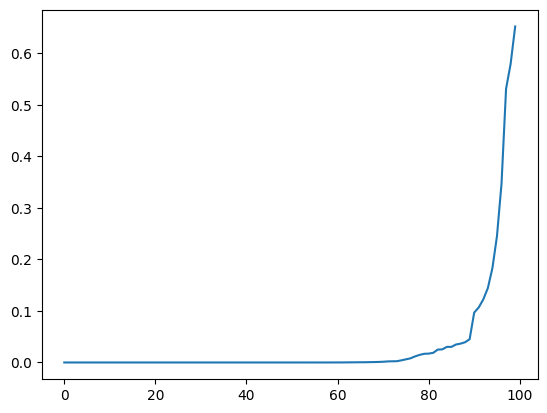

In [22]:
plt.plot(cvm_pvals)

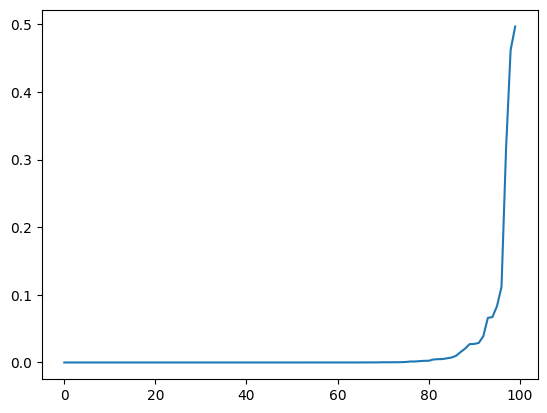

In [23]:
plt.plot(ks_pvals)

In [135]:
def generate(loc=0.0):
    base = np.random.normal(size=(100, 10)) # 1000 embeddings, 10 dimensions
    control_query = np.random.normal(size=(100, 10)) # 10 embedding, 10 dimensions
    queries = np.random.normal(loc=loc, size=(100, 10)) # 100 embedding, 10 dimensions

    control_dist = cdist(base, control_query)
    control_dist = control_dist.flatten()

    distances = cdist(base, queries)
    distances = distances.flatten()

    cvms = cramervonmises_2samp(control_dist, distances)
    kss = ks_2samp(control_dist, distances)
    return (cvms, kss)

locs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
cvms = [
    [
        generate(loc)[0]
        for _ in range(1000)
    ]
    for loc in locs
]
cvm_pvalues = [
    sorted([
        float(metric.pvalue)
        for metric in cvm
    ])
    for cvm in cvms
]
cvm_statistics = [
    sorted([
        float(metric.statistic)
        for metric in cvm
    ])
    for cvm in cvms
]

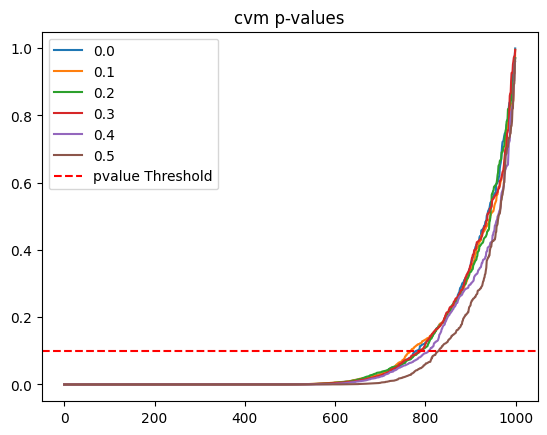

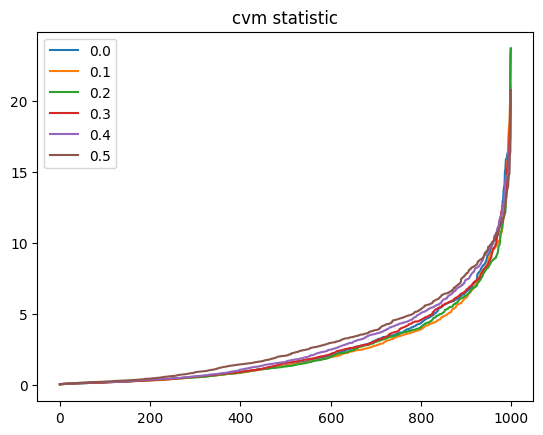

In [136]:
plt.figure()
for offset, metric in zip(locs, cvm_pvalues):
    plt.plot(metric, label=str(offset))
plt.title("cvm p-values")
plt.axhline(y=0.1, color='r', linestyle='--', label='pvalue Threshold')
plt.legend()
plt.show()

plt.figure()
for offset, metric in zip(locs, cvm_statistics):
    plt.plot(metric, label=str(offset))
plt.title("cvm statistic")
plt.legend()
plt.show()
